In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from collections import defaultdict
import os, zipfile
import tensorflow as tf
from collections import Counter
import numpy as np
from collections import deque
import math
from IPython.display import clear_output
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors
import random


%matplotlib inline

In [3]:
filepath = "/Users/kate/Downloads/enwik8.zip"

def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


words = read_data(filepath)
print("data_size = {0}".format(len(words)))

data_size = 13303079


In [4]:
def build_dataset(words, vocabulary_size):
    count = [[ "UNK", -1 ]]
    count.extend(Counter(words).most_common(vocabulary_size-1))
    print("Least frequent word: ", count[-1])
    word_to_index = { word: i for i, (word, _) in enumerate(count) }
    data = [word_to_index.get(word, 0) for word in words] # map unknown words to 0
    unk_count = data.count(0) # Number of unknown words
    count[0][1] = unk_count
    index_to_word= dict(zip(word_to_index.values(), word_to_index.keys()))
    
    return data, count, word_to_index, index_to_word

vocabulary_size = 50000
data, count, word_to_index, index_to_word = build_dataset(words, vocabulary_size)

# Everything you need to know about the dataset

print("data: {0}".format(data[:10]))
print("count: {0}".format(count[:10]))
print("index_to_word: {0}".format(list(index_to_word.items())[:10]))

Least frequent word:  ('heuristic', 16)
data: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
count: [['UNK', 2456460], ('the', 706962), ('of', 482580), ('and', 320272), ('in', 248527), ('to', 243008), ('a', 220374), ('is', 142939), ('as', 94840), ('The', 93111)]
index_to_word: [(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'in'), (5, 'to'), (6, 'a'), (7, 'is'), (8, 'as'), (9, 'The')]


In [5]:
def generate_batch(data_index, data_size, batch_size, bag_window):
    span = 2 * bag_window + 1 # [ bag_window, target, bag_window ]
    batch = np.ndarray(shape = (batch_size, span - 1), dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    
    data_buffer = deque(maxlen = span)
    
    for _ in range(span):
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
        
    for i in range(batch_size):
        data_list = list(data_buffer)
        labels[i, 0] = data_list.pop(bag_window)
        batch[i] = data_list
        
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    return data_index, batch, labels


print("data = {0}".format([index_to_word[each] for each in data[:16]]))
data_index, data_size, batch_size = 0, len(data), 4
for bag_window in [1, 2]:
    data_index, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
    print("bag_window = {0}".format(bag_window))
    print("batch = {0}".format([[index_to_word[index] for index in each] for each in batch]))
    print("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(4)]))

data = ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', '<namespace', 'UNK']
bag_window = 1
batch = [['UNK', 'UNK'], ['UNK', 'UNK'], ['UNK', 'UNK'], ['UNK', 'UNK']]
labels = ['UNK', 'UNK', 'UNK', 'UNK']

bag_window = 2
batch = [['UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', '<namespace']]
labels = ['UNK', 'UNK', 'UNK', 'UNK']



https://gist.github.com/yxtay/a94d971955d901c4690129580a4eafb9

https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac

задача: https://github.com/deepmipt/deep-nlp-seminars/blob/master/seminar_02/embeddings.ipynb

In [29]:
batch_size = 128

embedding_size = 128
vocab_size = 50000

bag_window = 2

tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():
    
    train_data = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2]) # center_words 
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) # target_words
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) # embed_matrix
    embed = tf.nn.embedding_lookup(embeddings, train_data) # embed
    
    ####################

    context_sum = tf.reduce_sum(embed, 1)
    scores = tf.matmul(context_sum, tf.transpose(embeddings))
    print(scores)
    
    one_hot_labels = tf.one_hot(train_labels, vocab_size)
    
    onehot_labels = tf.reshape(one_hot_labels, (batch_size, vocabulary_size))
    logits = tf.reshape(scores, (batch_size, vocabulary_size))
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_labels, logits=scores)
    
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
    normalized_embeddings = embeddings / norm
    print(normalized_embeddings)

Tensor("MatMul:0", shape=(128, 50000), dtype=float32)
Tensor("truediv:0", shape=(50000, 128), dtype=float32)


In [32]:
%%time
num_steps = 50000
loss_every_nsteps = 200
from IPython.display import clear_output


with tf.Session(graph=graph) as sess:
    try:
        tf.global_variables_initializer().run()
        print('Initialized')
        average_loss = 0

        for step in range(num_steps):
            data_index, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
            feed_dict = { train_data: batch, train_labels: labels }
            _, current_loss = sess.run([optimizer, loss], feed_dict = feed_dict)
            average_loss += current_loss
            if step % loss_every_nsteps == 0:
                if step > 0:
                    average_loss = average_loss / loss_every_nsteps
                    clear_output(True)
                    print ("step = {0}, average_loss = {1}".format(step, average_loss))
                    average_loss = 0
    except KeyboardInterrupt:
        final_embeddings = normalized_embeddings.eval()
    final_embeddings = normalized_embeddings.eval()

step = 49800, average_loss = [ 7.82977581  7.32004404  7.49948549  7.58399057  7.31103897  7.63499928
  7.38087034  7.54234886  7.37035036  7.81080151  7.35438395  7.24017763
  7.53865767  7.68950319  7.28892136  7.43489218  6.85360765  7.28986454
  7.39963865  7.2319684   7.61438417  7.36611366  7.76483154  7.33908653
  7.64389277  7.66062546  7.62812662  7.26259947  7.26649761  7.47972822
  7.16354322  7.24622726  7.30714655  7.85141277  7.31315136  7.60127449
  7.26595497  7.57919979  7.33032703  7.29412174  7.52142143  7.57751703
  8.06596756  7.56347275  7.93354654  7.13514757  7.64448309  7.79666424
  7.17534304  7.23915386  7.07685995  6.92233992  7.14465523  7.28514719
  7.33262014  7.54014635  8.02314377  8.04254913  7.56905031  7.8256321
  7.81305838  7.77651739  7.5363574   7.55652142  7.26752377  7.45281267
  7.88314629  7.78070068  7.72388506  8.04455471  7.25699663  7.59199333
  6.8892827   7.20843124  7.28644943  7.46172285  7.13410664  7.35022545
  7.67598248  7.1305003

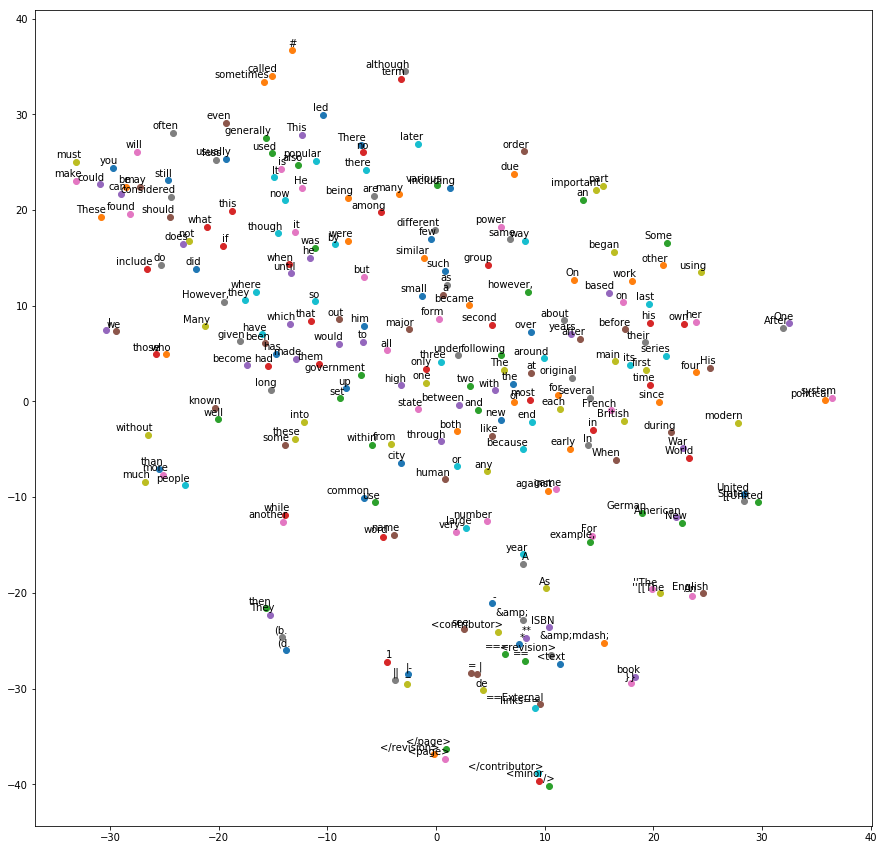

In [35]:
num_points = 250

tsne = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

plt.figure(figsize=(15,15))
words = [index_to_word[i] for i in range(1, num_points+1)]

for i, label in enumerate(words):
    x, y = two_d_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
plt.show()

In [34]:
def generate_batch_2(data_index, data_size, batch_size, num_skips, skip_window):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape = batch_size, dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    span = 2 * skip_window + 1
    data_buffer = deque(maxlen = span)
    for _ in range(span):
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    
    for i in range(batch_size // num_skips):
        target, targets_to_avoid = skip_window, [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid: 
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = data_buffer[skip_window]
            labels[i * num_skips + j, 0] = data_buffer[target]
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    return data_index, batch, labels


print ("data = {0}\n".format([index_to_word[each] for each in data[:32]]))
data_index, data_size = 0, len(data)
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    data_index, batch, labels = generate_batch_2(data_index=data_index, 
                                               data_size=data_size, 
                                               batch_size=16, 
                                               num_skips=num_skips, 
                                               skip_window=skip_window)
    print ("data_index = {0}, num_skips = {1}, skip_window = {2}".format( data_index, num_skips, skip_window))
    print ("batch = {0}".format([index_to_word[each] for each in batch]))
    print ("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(16)]))

data = ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', '<namespace', 'UNK', '<namespace', 'UNK', '<namespace', 'UNK', '/>', '<namespace', 'UNK', '<namespace', 'UNK', '<namespace', 'UNK', 'UNK', '<namespace', 'UNK', '<namespace', 'UNK']

data_index = 11, num_skips = 2, skip_window = 1
batch = ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']
labels = ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']

data_index = 9, num_skips = 4, skip_window = 2
batch = ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']
labels = ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']



In [49]:
batch_size = 128

embedding_size = 128
vocab_size = 50000

bag_window = 2
skip_window = 4
num_scips = 128

In [50]:
# scip-gram model
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():
    embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], 
                                                  stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                 biases=nce_biases,
                 labels=train_labels,
                 inputs=embed,
                 num_sampled=embedding_size,
                 num_classes=vocab_size))
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss) 
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
    normalized_embeddings = embeddings / norm
    print(normalized_embeddings)

Tensor("truediv:0", shape=(50000, 128), dtype=float32)


In [51]:
%%time
num_steps = 50000
loss_every_nsteps = 200

with tf.Session(graph=graph) as sess:
    try:
        tf.global_variables_initializer().run()
        print('Initialized')
        average_loss = 0

        for step in range(num_steps):
            data_index, batch, labels = generate_batch_2(data_index, data_size, batch_size, num_skips, skip_window)
            feed_dict = { train_inputs: batch, train_labels: labels }
            _, current_loss = sess.run([optimizer, loss], feed_dict = feed_dict)
            average_loss += current_loss
            if step % loss_every_nsteps == 0:
                if step > 0:
                    average_loss = average_loss / loss_every_nsteps
                    average_loss = 0
    except KeyboardInterrupt:
        final_embeddings = normalized_embeddings.eval()
    final_embeddings = normalized_embeddings.eval()

Initialized
CPU times: user 3min 8s, sys: 20.3 s, total: 3min 28s
Wall time: 1min 47s


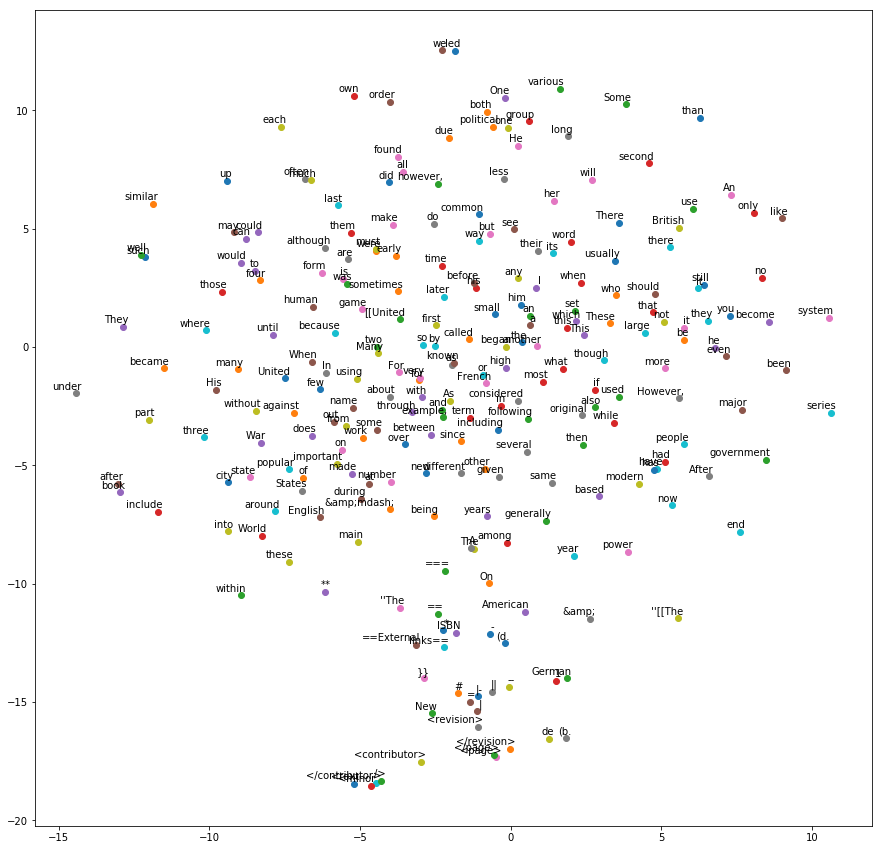

In [52]:
num_points = 250

tsne = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

plt.figure(figsize=(15,15))
words = [index_to_word[i] for i in range(1, num_points+1)]

for i, label in enumerate(words):
    x, y = two_d_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
plt.show()

P.S. чтобы не мусорить .ipynb для проверки, убрала ту часть, где надо было не писать свой код, а просто посмотреть как работает